## Environment setup

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'GHxaqiPvBshWK62qXNMy'

In [3]:
# Importing the Federal Reserve Economic Data "Producer Price Index - Lobsters" variable.

data = quandl.get('FRED/WPU02230503')

In [4]:
data.head()

,Value
Date,
1991-12-01,100.0
1992-01-01,100.8
1992-02-01,134.0
1992-03-01,187.3
1992-05-01,111.8


In [5]:
data.shape

(243, 1)

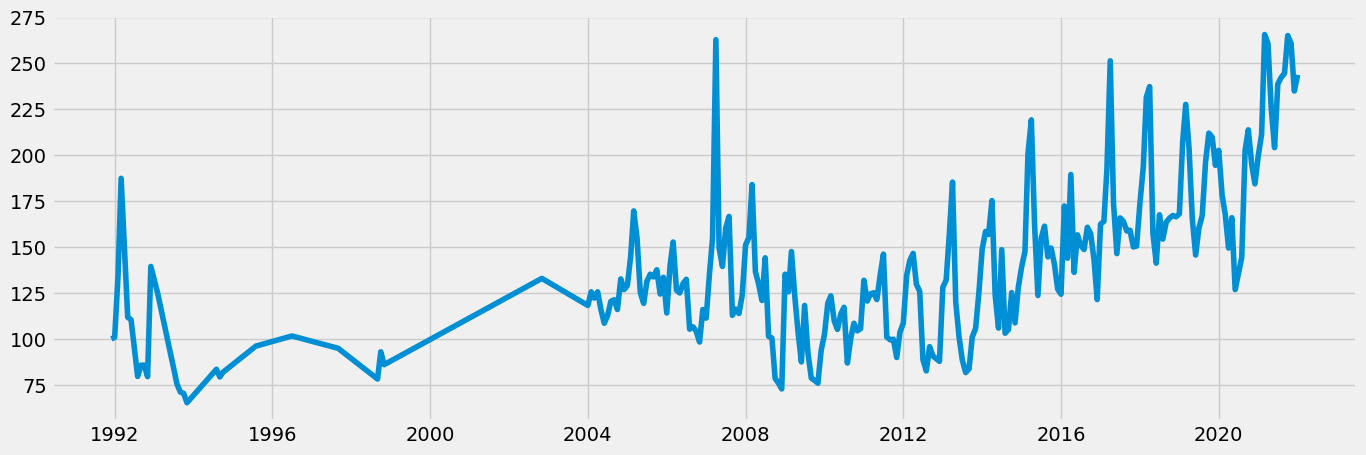

In [6]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

## Subsetting, wrangling, and cleaning time-series data

In [7]:
# reset index
data_2 = data.reset_index()

In [8]:
data_2.columns

Index(['Date', 'Value'], dtype='object')

In [9]:
data_2.head()

,Date,Value
0,1991-12-01,100.0
1,1992-01-01,100.8
2,1992-02-01,134.0
3,1992-03-01,187.3
4,1992-05-01,111.8


In [10]:
# create subset with data from 2008 - 2022 (same time period as fishery data)
data_sub = data_2.loc[data_2['Date'] >= '2008-01-01']

In [11]:
data_sub.shape

(169, 2)

In [12]:
data_sub.head()

,Date,Value
74,2008-01-01,151.1
75,2008-02-01,155.2
76,2008-03-01,183.9
77,2008-04-01,136.6
78,2008-05-01,129.8


In [13]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2008-01-01,151.1
2008-02-01,155.2
2008-03-01,183.9
2008-04-01,136.6
2008-05-01,129.8


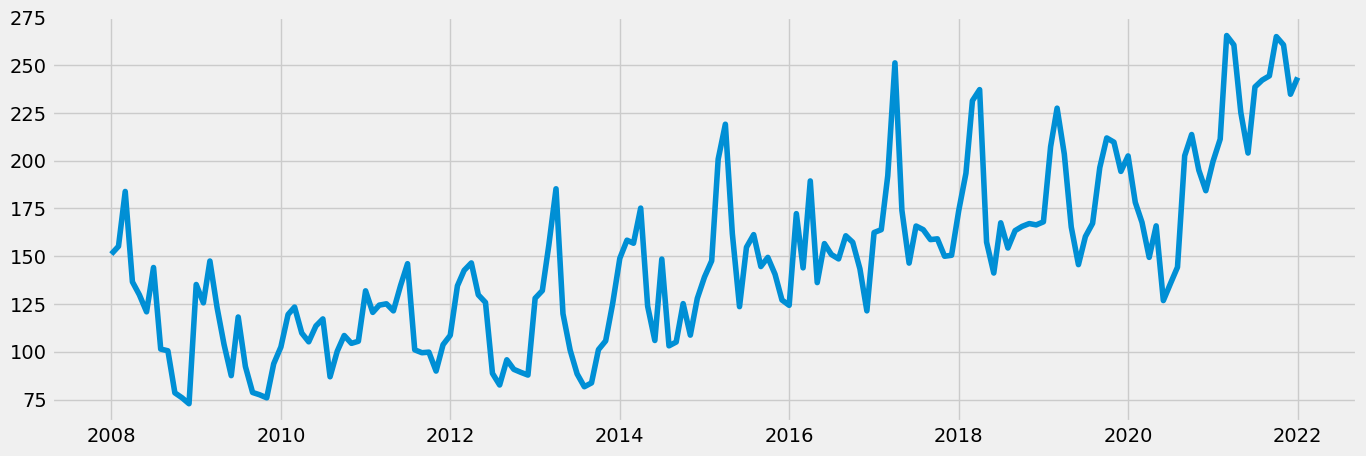

In [14]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [15]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [16]:
# Check for duplicates

dups = data_sub[data_sub.duplicated()]
dups

,Value
datetime,
2009-11-01,75.9
2012-05-01,129.8
2013-12-01,125.1
2016-12-01,121.4
2017-08-01,163.9
2020-04-01,149.4


In [17]:
data_sub = data_sub.drop_duplicates() # 6 duplicates deleted

In [18]:
data_sub.shape

(163, 1)

In [19]:
# double check
data_sub.duplicated().sum()

0

## Time series analysis: decomposition

In [20]:
# Decompose the time series using an additive model - for some reason it made me add a period

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period=12)

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

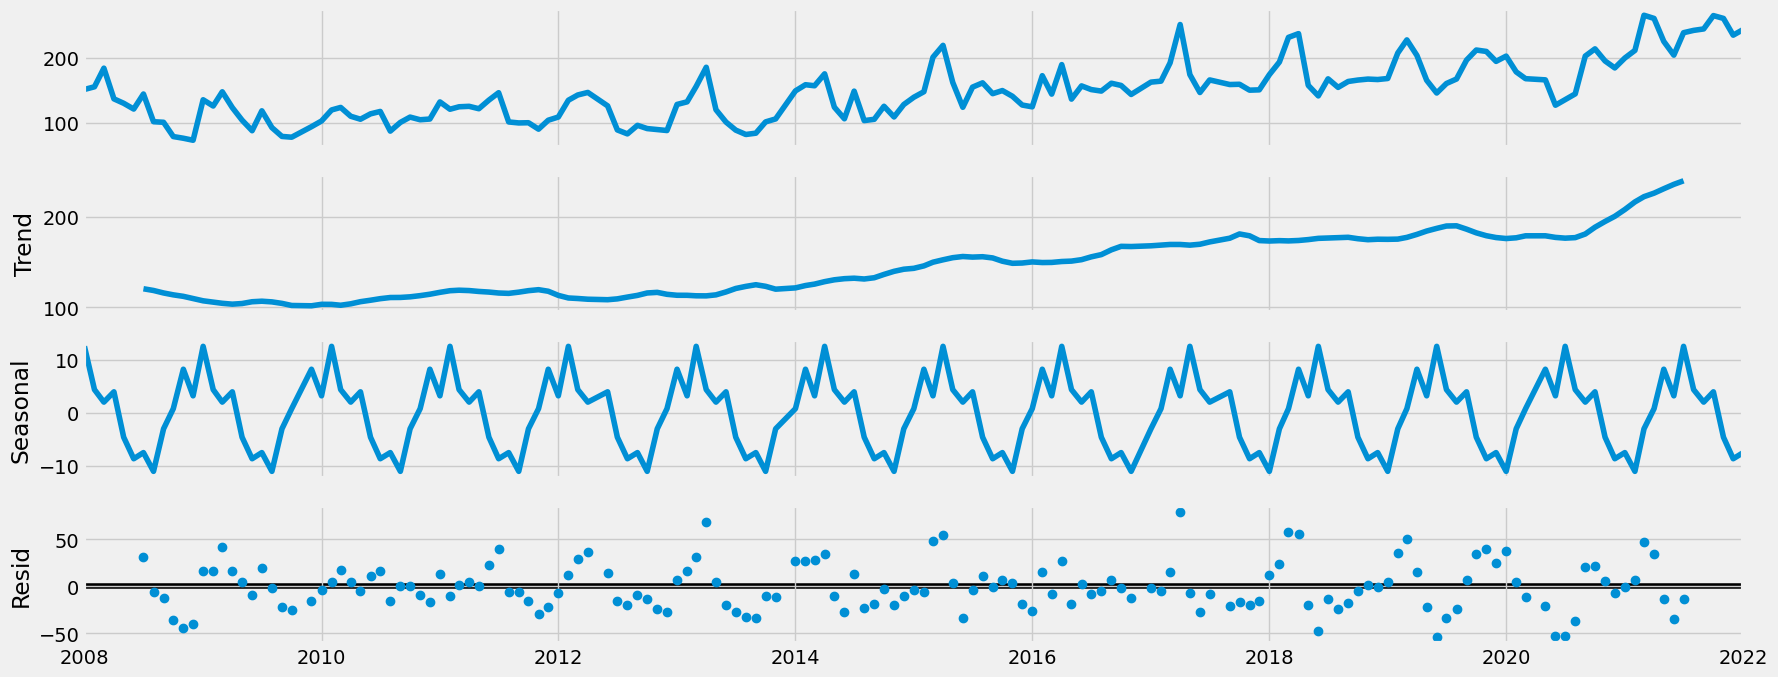

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()

## Testing for stationarity

In [23]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.525944
p-value                          0.997617
Number of Lags Used             10.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


Critical value at 5% is much smaller than test statistics, so we can't reject the null hypothesis; data is non-stationary. 

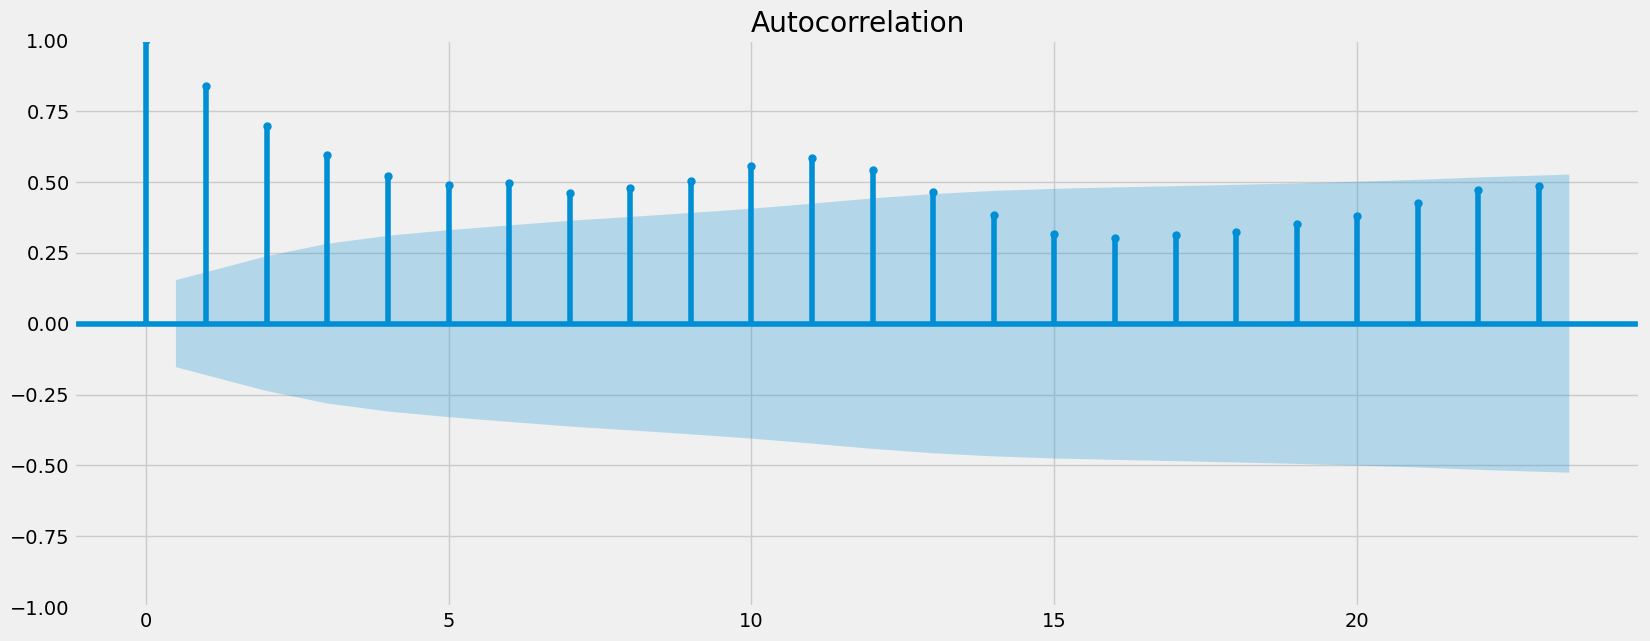

In [24]:
# Check for autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

Lags go beyond confidence interval; data is non-stationary.

## Stationarizing data

In [25]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [26]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [27]:
data_diff.head()

,Value
datetime,
2008-02-01,4.1
2008-03-01,28.7
2008-04-01,-47.3
2008-05-01,-6.8
2008-06-01,-8.9


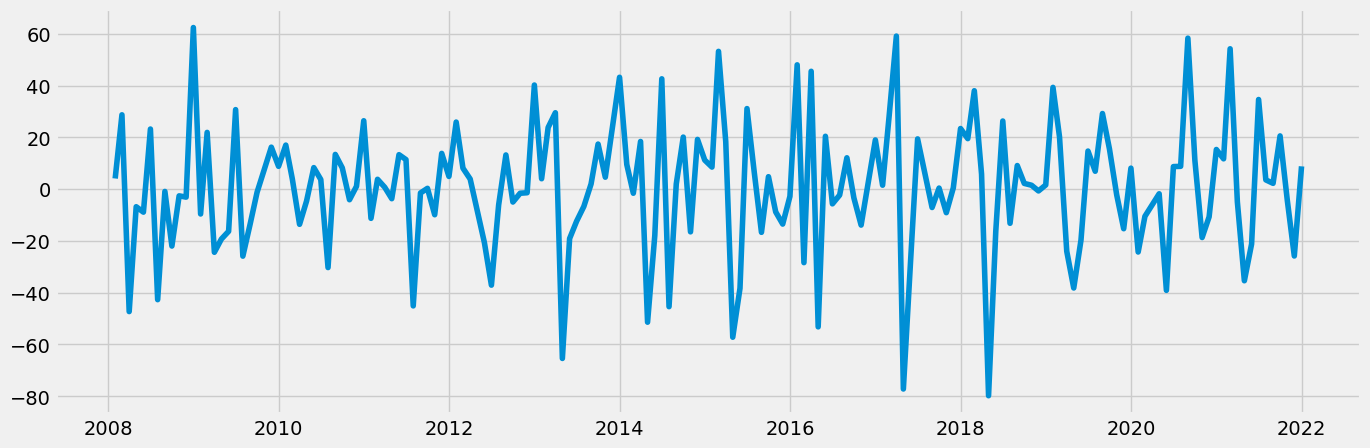

In [28]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.062398e+00
p-value                        4.526124e-15
Number of Lags Used            9.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


Test statistics now smaller than 5% critical value; data is stationary.

In [34]:
# exporting clean data_sub
data_sub.to_csv(r'/Users/Cel/Documents/Data Analytics/6. Maine Fisheries Landings/02 Data/Prepared Data/lobster_ppi.csv')